In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

def ClassPrintMetrics(y_real, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_real, y_pred)

    y_real_labels = list(map(str,sorted(y_real.unique().tolist())))

    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=y_real_labels)

    disp.plot()

    print(metrics.classification_report(y_real, y_pred))


dataset = pd.read_csv(r"..\data\processed\feature_all.txt", delimiter=" ")


Phishing?
0    426156
1     81015
Name: count, dtype: int64

<Axes: >

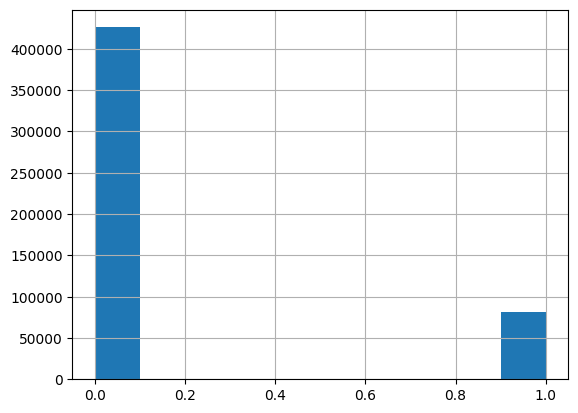

In [3]:
display(dataset["Phishing?"].value_counts())
# quality_num_bins = np.sort(dataset["Phishing?"].unique()) # Num bins = Num of unique target values
dataset["Phishing?"].hist()

In [4]:
url_train, url_dummy = train_test_split(dataset, test_size=0.2)
url_val, url_test = train_test_split(url_dummy, test_size=0.5)

In [5]:
url_train_x = url_train.drop(columns="Phishing?", inplace=False)
url_train_y = url_train["Phishing?"]

url_val_x = url_val.drop(columns="Phishing?", inplace=False)
url_val_y = url_val["Phishing?"]

url_test_x = url_test.drop(columns="Phishing?", inplace=False)
url_test_y = url_test["Phishing?"]

In [6]:
from benchmark import PerformanceMonitor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# Wichtig: Das Modul metrics muss verfügbar sein
from sklearn import metrics as sklearn_metrics 
from xgboost import XGBClassifier
import numpy as np

# 1. Monitor initialisieren
monitor = PerformanceMonitor("XGBoost")

# --- TRAINING ---
print("Starte Training...")
monitor.start_measurement()

# --- VORBEREITUNG ---
# Daten vorher umwandeln, um Kopieren während des Trainings zu vermeiden
X_train = url_train_x.astype('float32')
y_train = url_train_y.astype('float32')
X_val = url_val_x.astype('float32')
y_val = url_val_y.astype('float32')


bst = XGBClassifier(
    n_estimators=5000,
    max_depth=6,
    learning_rate=0.01,
    objective='binary:logistic',
    early_stopping_rounds=50,
    tree_method="hist",  # Effizientester Algorithmus für GPU
    device="cuda"        # Aktiviert die GPU
)

# Training durchführen
# Wir nutzen .astype(float), um Warnungen bei booleschen/object Spalten zu vermeiden
bst.fit(
    url_train_x.astype(float), 
    url_train_y.astype(float),
    eval_set=[(url_val_x.astype(float), url_val_y.astype(float))], 
    verbose=False
)

monitor.end_measurement(task_name="Training")


f:\GitHub Repositorys\Evaluation_of_AI_Models\.venv\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Starte Training...


KeyboardInterrupt: 

Starte Inferenz (gesamtes Testset)...


c:\Users\Benedikt Lang\Desktop\IP_2\Modells\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [18:16:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


--- Ergebnisse XGBoost (Inferenz) ---
Zeit: 1.4053s | GPU-Last: 69.6%
VRAM (System): 2058.07 MB | VRAM (Torch): 0.0 MB

--- Detail-Report (Scikit-Learn) ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     42603
           1       0.99      0.96      0.97      8115

    accuracy                           0.99     50718
   macro avg       0.99      0.98      0.98     50718
weighted avg       0.99      0.99      0.99     50718



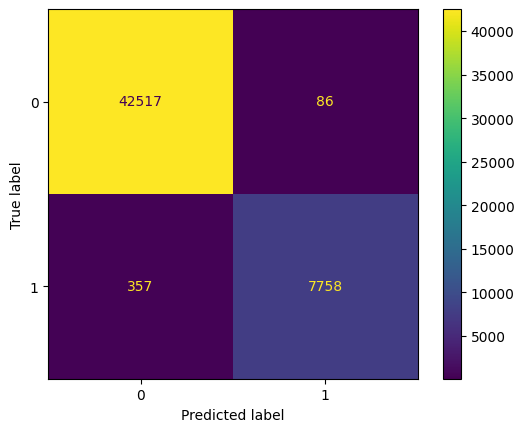

In [6]:
# --- INFERENZ ---
print("Starte Inferenz (gesamtes Testset)...")
monitor.start_measurement()

X_test_ready = url_test_x.astype(float)
y_scores = bst.predict_proba(X_test_ready)[:, 1]
y_pred = bst.predict(X_test_ready)

# --- METRIKEN BERECHNEN ---
y_true = url_test_y.astype(float).values

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_scores)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

# KORREKTUR: Dictionary umbenannt, damit 'metrics' Modul nicht überschrieben wird
metrics_dict = {
    "accuracy": round(acc, 4),
    "precision": round(prec, 4),
    "recall": round(rec, 4),
    "f1_score": round(f1, 4),
    "auc": round(auc, 4),
    "fpr": round(fpr, 4)
}

monitor.end_measurement(task_name="Inferenz", extra_metrics=metrics_dict)

print("\n--- Detail-Report (Scikit-Learn) ---")
# Da wir 'metrics' nicht überschrieben haben, funktioniert dieser Aufruf jetzt wieder:
ClassPrintMetrics(url_test_y, y_pred)